# Image Captioning with Attention

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
tf.enable_eager_execution(config)

# from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle

# import re
import numpy as np
# import os
# import time
# import json
# from glob import glob
from PIL import Image
# import pickle
from DataDownloader.mscocodownloader import MSCocoDownloader
from Models.inceptionmodel import InceptionModel
from Utils.visualiser import Visualiser
from DatasetGeneration.datasetgeneratornolabels import DatasetGeneratorNoLabels
from DatasetGeneration.datasetgenerator import DatasetGenerator
from Models.attentionmodel import AttentionModel
from Models.Helpers.tokenisations import Tokenisations

## 1. Preparing the Data Download

In [3]:
# Sample Count - number of images used to train and validatate the model, set to be None to include the whole dataset
sample_count = 8000

In [4]:
mscoco = MSCocoDownloader(sample_count)

In [5]:
mscoco.image_name_vector[0:5]

['D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000324909.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000511972.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000508809.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000270497.jpg',
 'D:\\Repos\\ImageCaptioningWithAttention/train2014/COCO_train2014_000000008014.jpg']

In [6]:
mscoco.train_captions[0:5]

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>',
 '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>',
 '<start> Small child in a high chair eating off of a green plate.  <end>']

## 2. Visualising the Data (Optional)

In [7]:
vis = Visualiser()

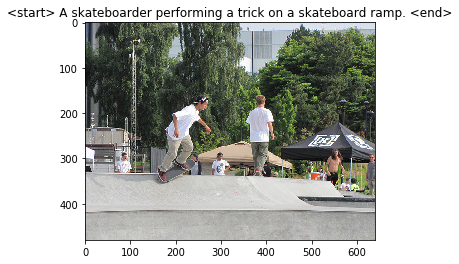

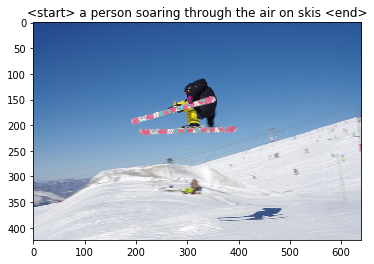

In [8]:
vis.show_image(mscoco.image_name_vector[0],mscoco.train_captions[0])
vis.show_image(mscoco.image_name_vector[1],mscoco.train_captions[1])

## 3. Faster Training by Processing Images through Inception V3

In [9]:
encode_train = sorted(set(mscoco.image_name_vector))
inmodel = InceptionModel()
datasetGeneratorNoLabels = DatasetGeneratorNoLabels(encode_train)

In [10]:
inmodel.cache_to_numpy_files_forward_pass(datasetGeneratorNoLabels.dataset)

598it [15:37,  1.53s/it]


## 4. Preprocess and tokenize the captions

In [10]:
tokenisations = Tokenisations()

In [11]:
tokenisations.prepare_training_tokens(mscoco.train_captions)
tokenisations.save_tokeniser()

## 5. Split Training and Testing

In [12]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(mscoco.image_name_vector, 
                                                                    tokenisations.cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

In [13]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(6400, 6400, 1600, 1600)

## 6. Dataset Generator from Inception Output 

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenisations.tokenizer.word_index)

attention_features_shape = 64

## 7. Model Creation

In [15]:
attentionModel = AttentionModel(tokenisations, embedding_dim, units, vocab_size, BATCH_SIZE, attention_features_shape, inmodel.image_features_extract_model)

In [16]:
datasetGenerator = DatasetGenerator(img_name_train, cap_train, BATCH_SIZE, BUFFER_SIZE)

## 8. Training

In [17]:
attentionModel.train(datasetGenerator.dataset, 10)

Processing 0: tf.Tensor(95.24552, shape=(), dtype=float32): : 0it [02:12, ?it/s]

Epoch 1 Batch 0 Loss 1.9438


Processing 20: tf.Tensor(62.444576, shape=(), dtype=float32): : 20it [05:04,  7.84s/it]

Epoch 1 Batch 20 Loss 1.2744


Processing 40: tf.Tensor(62.3703, shape=(), dtype=float32): : 40it [07:44,  7.66s/it]  

Epoch 1 Batch 40 Loss 1.2729


Processing 60: tf.Tensor(59.124302, shape=(), dtype=float32): : 60it [10:30,  7.89s/it]

Epoch 1 Batch 60 Loss 1.2066


Processing 80: tf.Tensor(62.905178, shape=(), dtype=float32): : 80it [13:20,  7.57s/it]

Epoch 1 Batch 80 Loss 1.2838


Processing 99: tf.Tensor(53.484756, shape=(), dtype=float32): : 100it [14:42,  3.04s/it]


Epoch 1 Loss 0.019956
Time taken for 1 epoch 883.5796303749084 sec



Processing 0: tf.Tensor(52.976116, shape=(), dtype=float32): : 0it [00:53, ?it/s]

Epoch 2 Batch 0 Loss 1.0811


Processing 20: tf.Tensor(53.651123, shape=(), dtype=float32): : 20it [02:25,  5.95s/it]

Epoch 2 Batch 20 Loss 1.0949


Processing 40: tf.Tensor(51.35498, shape=(), dtype=float32): : 40it [04:20,  6.48s/it] 

Epoch 2 Batch 40 Loss 1.0481


Processing 60: tf.Tensor(50.512966, shape=(), dtype=float32): : 60it [06:22,  7.32s/it]

Epoch 2 Batch 60 Loss 1.0309


Processing 80: tf.Tensor(53.8216, shape=(), dtype=float32): : 80it [08:42,  5.47s/it]  

Epoch 2 Batch 80 Loss 1.0984


Processing 99: tf.Tensor(45.897617, shape=(), dtype=float32): : 100it [09:58,  3.44s/it]


Epoch 2 Loss 0.016421
Time taken for 1 epoch 598.9930930137634 sec



Processing 0: tf.Tensor(49.13073, shape=(), dtype=float32): : 0it [00:47, ?it/s]

Epoch 3 Batch 0 Loss 1.0027


Processing 20: tf.Tensor(44.309433, shape=(), dtype=float32): : 20it [02:37,  4.60s/it]

Epoch 3 Batch 20 Loss 0.9043


Processing 40: tf.Tensor(38.85242, shape=(), dtype=float32): : 40it [04:21,  5.36s/it] 

Epoch 3 Batch 40 Loss 0.7929


Processing 60: tf.Tensor(44.778515, shape=(), dtype=float32): : 60it [06:07,  5.08s/it]

Epoch 3 Batch 60 Loss 0.9138


Processing 80: tf.Tensor(44.197544, shape=(), dtype=float32): : 80it [08:07,  5.22s/it]

Epoch 3 Batch 80 Loss 0.9020


Processing 99: tf.Tensor(45.744587, shape=(), dtype=float32): : 100it [09:22,  3.49s/it]


Epoch 3 Loss 0.014214
Time taken for 1 epoch 562.6872274875641 sec



Processing 0: tf.Tensor(39.723564, shape=(), dtype=float32): : 0it [00:45, ?it/s]

Epoch 4 Batch 0 Loss 0.8107


Processing 20: tf.Tensor(38.227505, shape=(), dtype=float32): : 20it [02:42,  5.63s/it]

Epoch 4 Batch 20 Loss 0.7802


Processing 40: tf.Tensor(40.67921, shape=(), dtype=float32): : 40it [04:26,  5.49s/it] 

Epoch 4 Batch 40 Loss 0.8302


Processing 60: tf.Tensor(43.85319, shape=(), dtype=float32): : 60it [06:21,  5.81s/it] 

Epoch 4 Batch 60 Loss 0.8950


Processing 80: tf.Tensor(39.65745, shape=(), dtype=float32): : 80it [08:12,  5.81s/it] 

Epoch 4 Batch 80 Loss 0.8093


Processing 99: tf.Tensor(35.43449, shape=(), dtype=float32): : 100it [09:23,  3.25s/it]


Epoch 4 Loss 0.012758
Time taken for 1 epoch 563.8819262981415 sec



Processing 0: tf.Tensor(36.607315, shape=(), dtype=float32): : 0it [00:45, ?it/s]

Epoch 5 Batch 0 Loss 0.7471


Processing 20: tf.Tensor(39.15086, shape=(), dtype=float32): : 20it [02:46,  6.52s/it] 

Epoch 5 Batch 20 Loss 0.7990


Processing 40: tf.Tensor(37.281593, shape=(), dtype=float32): : 40it [04:41,  5.29s/it]

Epoch 5 Batch 40 Loss 0.7608


Processing 60: tf.Tensor(36.582123, shape=(), dtype=float32): : 60it [06:30,  5.52s/it]

Epoch 5 Batch 60 Loss 0.7466


Processing 80: tf.Tensor(40.090466, shape=(), dtype=float32): : 80it [08:24,  6.41s/it]

Epoch 5 Batch 80 Loss 0.8182


Processing 99: tf.Tensor(38.479668, shape=(), dtype=float32): : 100it [09:38,  2.93s/it]


Epoch 5 Loss 0.011793
Time taken for 1 epoch 578.7219264507294 sec



Processing 0: tf.Tensor(34.5519, shape=(), dtype=float32): : 0it [00:43, ?it/s]

Epoch 6 Batch 0 Loss 0.7051


Processing 20: tf.Tensor(36.367405, shape=(), dtype=float32): : 20it [02:33,  4.51s/it]

Epoch 6 Batch 20 Loss 0.7422


Processing 40: tf.Tensor(35.263695, shape=(), dtype=float32): : 40it [04:34,  6.02s/it]

Epoch 6 Batch 40 Loss 0.7197


Processing 60: tf.Tensor(34.277283, shape=(), dtype=float32): : 60it [07:21, 16.36s/it]

Epoch 6 Batch 60 Loss 0.6995


Processing 80: tf.Tensor(34.93581, shape=(), dtype=float32): : 80it [09:21,  6.79s/it] 

Epoch 6 Batch 80 Loss 0.7130


Processing 99: tf.Tensor(34.814796, shape=(), dtype=float32): : 100it [10:47,  3.33s/it]


Epoch 6 Loss 0.011016
Time taken for 1 epoch 647.1441202163696 sec



Processing 0: tf.Tensor(34.634632, shape=(), dtype=float32): : 0it [01:30, ?it/s]

Epoch 7 Batch 0 Loss 0.7068


Processing 20: tf.Tensor(32.93303, shape=(), dtype=float32): : 20it [04:01,  7.49s/it] 

Epoch 7 Batch 20 Loss 0.6721


Processing 40: tf.Tensor(30.75878, shape=(), dtype=float32): : 40it [06:19,  7.08s/it] 

Epoch 7 Batch 40 Loss 0.6277


Processing 60: tf.Tensor(30.785845, shape=(), dtype=float32): : 60it [08:44,  8.01s/it]

Epoch 7 Batch 60 Loss 0.6283


Processing 80: tf.Tensor(33.227425, shape=(), dtype=float32): : 80it [11:00,  7.00s/it]

Epoch 7 Batch 80 Loss 0.6781


Processing 99: tf.Tensor(28.19286, shape=(), dtype=float32): : 100it [12:24,  3.99s/it]


Epoch 7 Loss 0.010318
Time taken for 1 epoch 744.6806075572968 sec



Processing 0: tf.Tensor(31.06407, shape=(), dtype=float32): : 0it [00:41, ?it/s]

Epoch 8 Batch 0 Loss 0.6340


Processing 20: tf.Tensor(32.00413, shape=(), dtype=float32): : 20it [02:05,  4.03s/it] 

Epoch 8 Batch 20 Loss 0.6531


Processing 40: tf.Tensor(27.562006, shape=(), dtype=float32): : 40it [03:57,  5.20s/it]

Epoch 8 Batch 40 Loss 0.5625


Processing 60: tf.Tensor(30.802225, shape=(), dtype=float32): : 60it [05:52,  5.87s/it]

Epoch 8 Batch 60 Loss 0.6286


Processing 80: tf.Tensor(28.008587, shape=(), dtype=float32): : 80it [07:38,  4.95s/it]

Epoch 8 Batch 80 Loss 0.5716


Processing 99: tf.Tensor(32.826004, shape=(), dtype=float32): : 100it [09:04,  3.53s/it]


Epoch 8 Loss 0.009620
Time taken for 1 epoch 544.2575266361237 sec



Processing 0: tf.Tensor(26.567268, shape=(), dtype=float32): : 0it [00:45, ?it/s]

Epoch 9 Batch 0 Loss 0.5422


Processing 20: tf.Tensor(28.455969, shape=(), dtype=float32): : 20it [02:27,  4.21s/it]

Epoch 9 Batch 20 Loss 0.5807


Processing 40: tf.Tensor(30.582493, shape=(), dtype=float32): : 40it [04:44,  9.26s/it]

Epoch 9 Batch 40 Loss 0.6241


Processing 60: tf.Tensor(28.132782, shape=(), dtype=float32): : 60it [06:41,  5.26s/it]

Epoch 9 Batch 60 Loss 0.5741


Processing 80: tf.Tensor(25.918089, shape=(), dtype=float32): : 80it [08:26,  4.73s/it]

Epoch 9 Batch 80 Loss 0.5289


Processing 99: tf.Tensor(28.99849, shape=(), dtype=float32): : 100it [09:40,  3.01s/it]


Epoch 9 Loss 0.008928
Time taken for 1 epoch 580.7248361110687 sec



Processing 0: tf.Tensor(26.451963, shape=(), dtype=float32): : 0it [00:53, ?it/s]

Epoch 10 Batch 0 Loss 0.5398


Processing 20: tf.Tensor(28.253515, shape=(), dtype=float32): : 20it [02:24,  5.53s/it]

Epoch 10 Batch 20 Loss 0.5766


Processing 40: tf.Tensor(26.780449, shape=(), dtype=float32): : 40it [04:16,  4.95s/it]

Epoch 10 Batch 40 Loss 0.5465


Processing 60: tf.Tensor(25.529217, shape=(), dtype=float32): : 60it [06:06,  5.22s/it]

Epoch 10 Batch 60 Loss 0.5210


Processing 80: tf.Tensor(25.257559, shape=(), dtype=float32): : 80it [07:57,  5.78s/it]

Epoch 10 Batch 80 Loss 0.5155


Processing 99: tf.Tensor(24.953709, shape=(), dtype=float32): : 100it [09:06,  2.93s/it]


Epoch 10 Loss 0.008304
Time taken for 1 epoch 546.1653513908386 sec



In [19]:
attentionModel.save_checkpoint2()

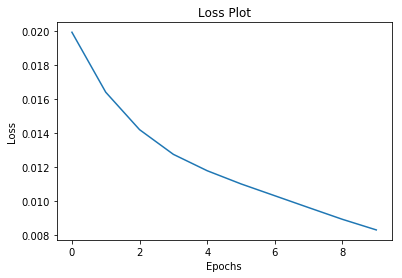

In [18]:
plt.plot(attentionModel.loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [36]:
attentionModel.load_checkpoint()

## 9. Validation Visualise

training_checkpoints2\ckpt
Real Caption: <start> many sheep are standing in a field next to their young ones <end>
Prediction Caption: a group of llamas in a baby sheeps <end>


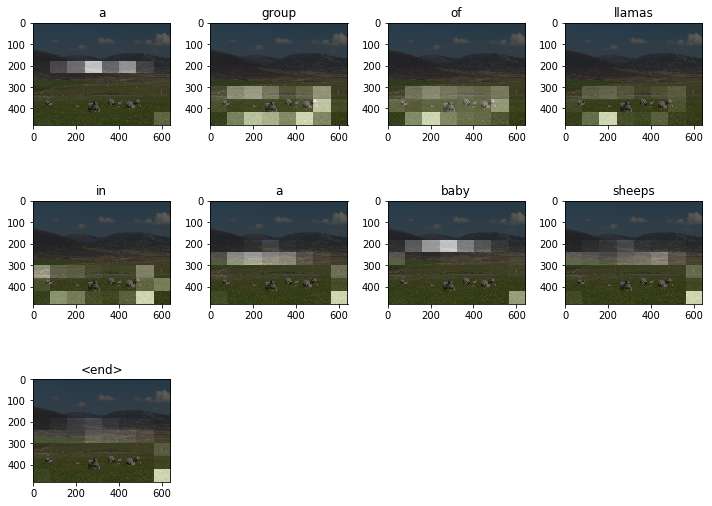

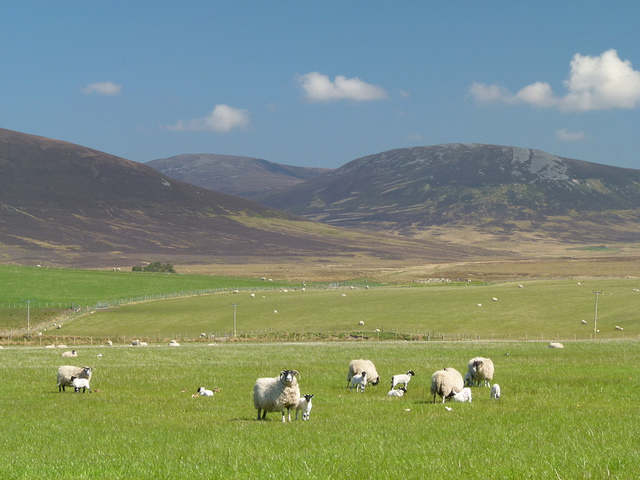

In [22]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
rid = 5
image = img_name_val[rid]
real_caption = ' '.join([tokenisations.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = attentionModel.evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
vis.plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

## 10. Predictions

Prediction Caption: a man on a gentle wave in the ocean <end>


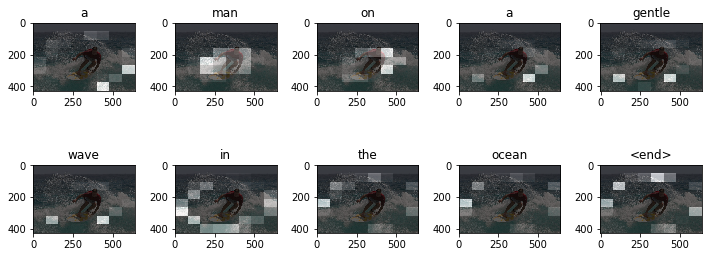

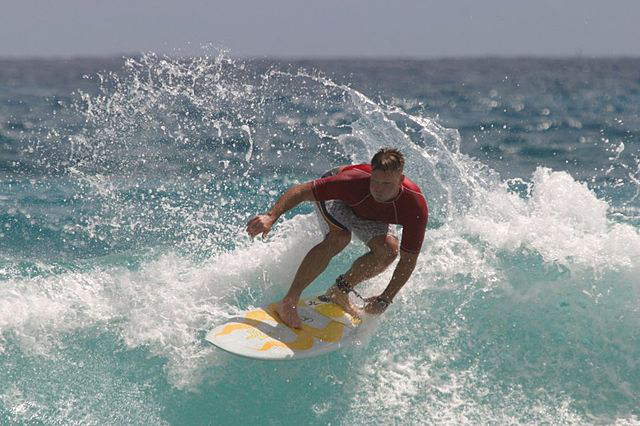

In [50]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, 
                                     origin=image_url)

result, attention_plot = attentionModel.evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
vis.plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)